<a href="https://colab.research.google.com/github/JoohoSon24/tire_competition/blob/main/FEM_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!mkdir -p data
!cp drive/MyDrive/25F/Tire/5-ai-and-datascience-competition.zip .
!unzip -q 5-ai-and-datascience-competition.zip -d data/

tab10_kwargs = {'cmap': 'tab10', 'vmin': 0, 'vmax': 9}

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, kurtosis, entropy, gaussian_kde
from sklearn.preprocessing import StandardScaler, LabelBinarizer, OneHotEncoder
from tqdm import tqdm

In [3]:
df_pub = pd.read_csv('data/train.csv')
df_exam = pd.read_csv('data/test.csv')

print(f"Train shape: {df_pub.shape}")
print(f"Test shape: {df_exam.shape}")

Train shape: (720, 799)
Test shape: (466, 799)


In [4]:
def split_data(df, train=True):
    cols_sim = [f'{ch}{i}' for i in range(256) for ch in ['x', 'y', 'p']]
    X_sum = df.drop(columns=cols_sim)
    X_fem = df[cols_sim]

    if train:
        X_sum = X_sum.drop(columns='Class')
        y = df['Class']
        return X_sum, X_fem, y
    else:
        X_sum = X_sum.drop(columns='ID')
        ids = df['ID']
        return X_sum, X_fem, ids

def plot_FEM(row, ax):
    if isinstance(row, pd.Series):
        row = row.values
    x, y, p = row.reshape(-1, 3).T
    im = ax.scatter(x, y, c=p, cmap='jet', s=0.5, vmin=1.2, vmax=3)
    plt.colorbar(im, ax=ax)
    ax.set_aspect('equal')

In [5]:
def anova(data, label):
    """
    ANOVA F-통계량의 R² (설명력) 계산
    """
    SST = ((data - data.mean()) ** 2).sum()
    SSR = 0
    for i in np.unique(label):
        mask = (label == i)
        SSR += mask.sum() * ((data[mask].mean() - data.mean()) ** 2).sum()
    return (SSR / SST).item()

def cramers_v(col1, col2):
    """
    범주형 변수 간 연관성 측정 (Cramér's V)
    """
    confusion_matrix = pd.crosstab(col1, col2)
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    min_dim = min(r-1, k-1)
    V = np.sqrt(chi2 / (n * min_dim))
    return V

In [6]:
def curve_length(x, y, p):
    P = np.stack([x, y], axis=-1)
    return np.sqrt((np.diff(P, axis=-2) ** 2).sum(axis=-1)).sum(axis=-1)

def stress_length(x, y, p, p_thr=2.5):
    P = np.stack([x, y], axis=-1)  # (N, l, 2)
    mask = (p > p_thr)  # (N, l)

    ls = []
    for i in range(p.shape[0]):
        P_stress = P[i, mask[i], :]  # (l', 2)
        l = np.sqrt((np.diff(P_stress, axis=0) ** 2).sum(axis=-1)).sum(axis=-1)
        ls.append(l)
    ls = np.array(ls)

    return ls

def bend_extent(x, y, p):
    return (y.max(axis=-1) - y.min(axis=-1)) / (x.max(axis=-1) - x.min(axis=-1))

def max_curvature(x, y, p, window_size=50, fisher=True, bias=True):
    x = np.asarray(x)
    y = np.asarray(y)

    B, N = y.shape
    if N < window_size:
        raise ValueError("window_size must be <= sequence length N")

    max_kurtosis = np.zeros(B)

    for b in tqdm(range(B), desc="Computing kurtosis"):
        y_curve = y[b]
        kurt_vals = []

        for i in range(N - window_size + 1):
            w = y_curve[i : i + window_size]
            k = kurtosis(w, fisher=fisher, bias=bias)
            kurt_vals.append(k)

        max_kurtosis[b] = np.max(kurt_vals)

    return max_kurtosis

def max_curvature(x, y, p):
    dx  = np.gradient(x, axis=1)
    dy  = np.gradient(y, axis=1)
    ddx = np.gradient(dx, axis=1)
    ddy = np.gradient(dy, axis=1)

    num = np.abs(dx * ddy - dy * ddx)
    den = (dx**2 + dy**2)**1.5 + 1e-9

    curvature = num / den
    max_kappa = np.max(curvature, axis=1)
    return max_kappa

def FEM_feat(rows, fn=lambda x, y, p: p.max(axis=-1)):
    if isinstance(rows, (pd.Series, pd.DataFrame)):
        rows = rows.values
    x, y, p = np.transpose(rows.reshape(-1, rows.shape[1] // 3, 3), axes=(2, 0, 1))
    return fn(x, y, p)

In [7]:
def JS_div(x, y, num_points=512, clip=(-np.inf, np.inf)):
    """
    KDE 기반 JS divergence (추천)
    x, y: 1D array
    num_points: PDF 평가를 위한 grid resolution
    """
    x = np.clip(x, *clip)
    y = np.clip(y, *clip)

    kde_p = gaussian_kde(x)
    kde_q = gaussian_kde(y)

    xmin = min(x.min(), y.min())
    xmax = max(x.max(), y.max())
    grid = np.linspace(xmin, xmax, num_points)

    p = kde_p(grid)
    q = kde_q(grid)

    eps = 1e-12
    p = p + eps
    q = q + eps
    p /= p.sum()
    q /= q.sum()

    m = 0.5 * (p + q)

    js = 0.5 * entropy(p, m) + 0.5 * entropy(q, m)
    return js

In [8]:
X_sum, X_fem, cl_ = split_data(df_pub)

# 레이블 인코딩
le = LabelBinarizer()
cl = le.fit_transform(cl_).squeeze(-1)

print(f"Summary features shape: {X_sum.shape}")
print(f"FEM features shape: {X_fem.shape}")
print(f"Labels: {np.unique(cl_)}")
print(f"Class distribution: {pd.Series(cl_).value_counts()}")

Summary features shape: (720, 30)
FEM features shape: (720, 768)
Labels: ['Good' 'NG']
Class distribution: Class
Good    613
NG      107
Name: count, dtype: int64


In [9]:
max_pressure = FEM_feat(X_fem, fn=lambda x, y, p: p.max(axis=-1))
print(f"Max pressure shape: {max_pressure.shape}")

# 곡선 길이
curve_len = FEM_feat(X_fem, fn=curve_length)
print(f"Curve length shape: {curve_len.shape}")

# 굽힘 정도
bend = FEM_feat(X_fem, fn=bend_extent)
print(f"Bend extent shape: {bend.shape}")

max_k = FEM_feat(X_fem, fn=max_curvature)
print(f"Max kurtosis shape: {max_k.shape}")

stress_len = FEM_feat(X_fem, fn=stress_length)
print(f"Stress length shape: {curve_len.shape}")

Max pressure shape: (720,)
Curve length shape: (720,)
Bend extent shape: (720,)
Max kurtosis shape: (720,)
Stress length shape: (720,)


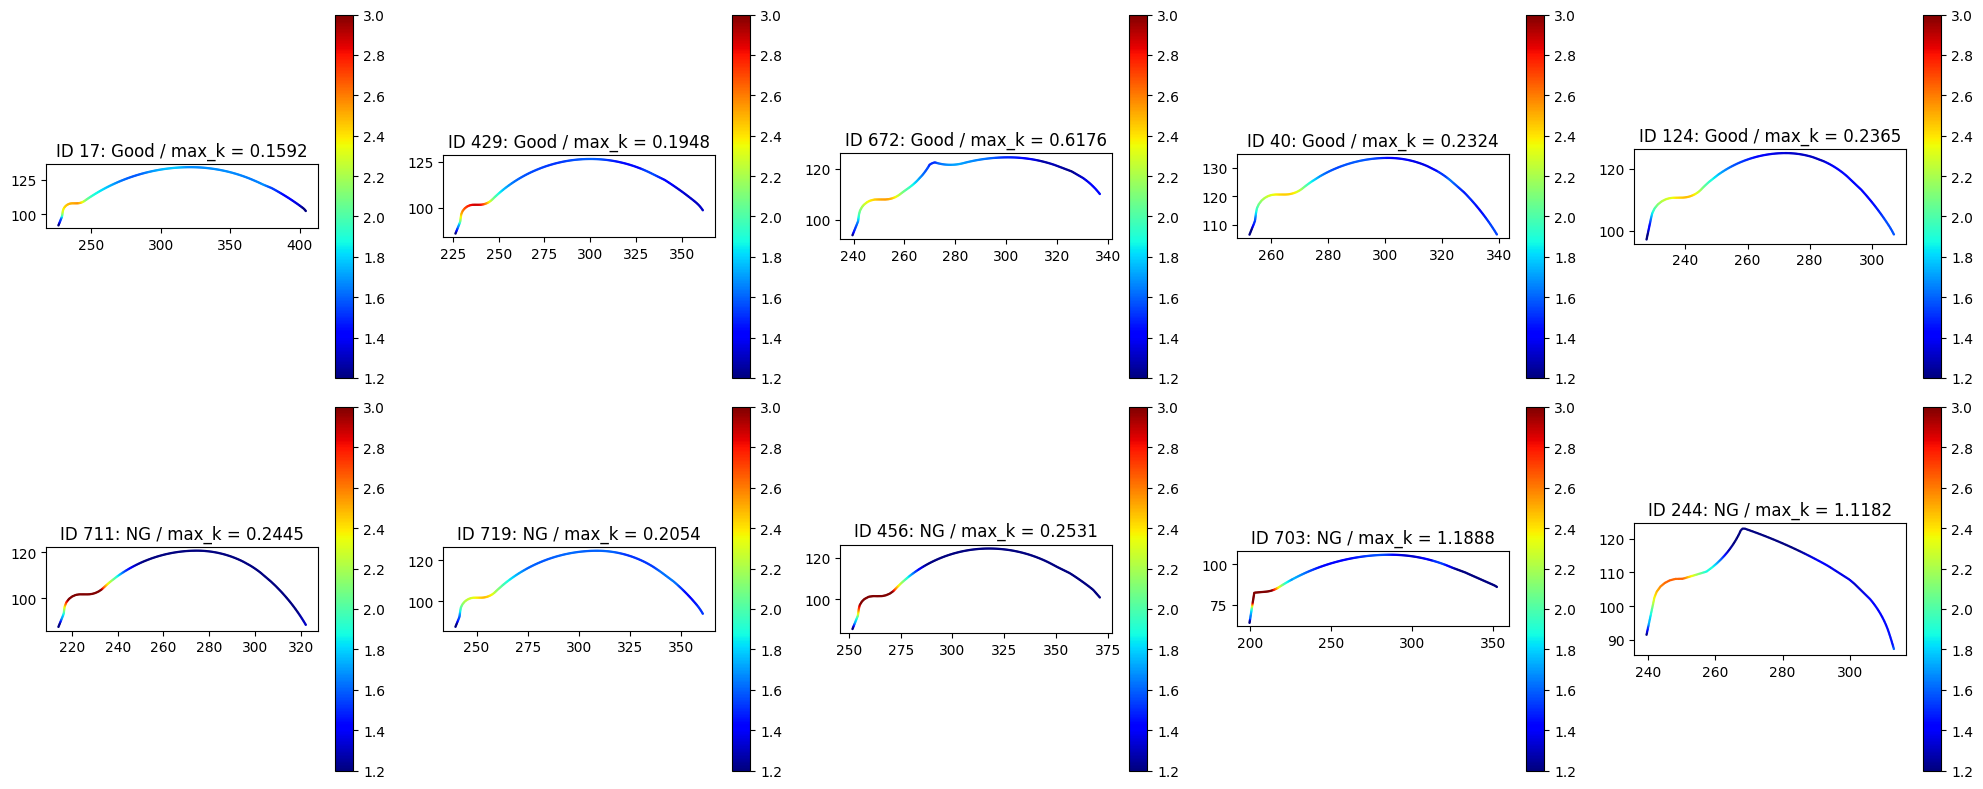

In [10]:
r, c = 2, 5
N = len(df_pub)
fig, axes = plt.subplots(r, c, figsize=(c * 4, r * 4))

for i in range(r):
  for j in range(c):
    mask = (cl == i).ravel()
    id = np.random.choice(np.arange(N)[mask])
    ax = axes[i][j]
    plot_FEM(X_fem.iloc[id], ax)
    ax.set_title(f"ID {id}: {cl_[id]} / max_k = {max_k[id]:.4f}")

plt.tight_layout()

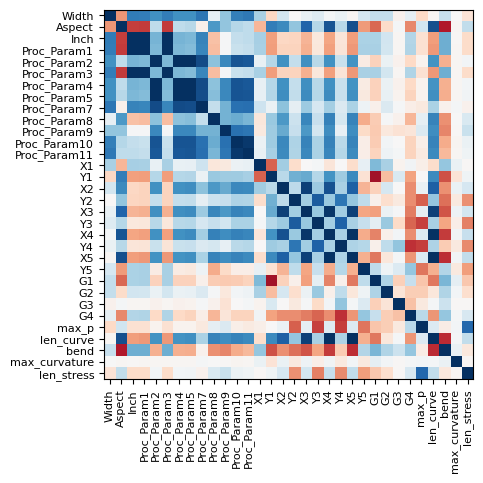

In [11]:
X_num = X_sum.select_dtypes(exclude=[bool, object])
X_num['max_p'] = max_pressure
X_num['len_curve'] = curve_len
X_num['bend'] = bend
X_num['max_curvature'] = max_k
X_num['len_stress'] = stress_len

Corr = X_num.corr().values
plt.imshow(Corr, cmap='RdBu', vmin=-1, vmax=1)
plt.xticks(ticks=np.arange(X_num.shape[1]), labels=X_num.columns, fontsize=8, rotation=90)
_ = plt.yticks(ticks=np.arange(X_num.shape[1]), labels=X_num.columns, fontsize=8, rotation=0)

In [12]:
for col in X_num.columns:
  feat = X_num[col].values
  clip = (-np.inf, np.inf)
  js = JS_div(feat[cl == 0], feat[cl == 1], clip=clip)
  eta_sq = anova(feat, cl)
  print(f"{col}: JS_div={js:.4f}, eta-square={eta_sq:.4f}")

Width: JS_div=0.0101, eta-square=0.0013
Aspect: JS_div=0.0377, eta-square=0.0241
Inch: JS_div=0.0250, eta-square=0.0074
Proc_Param1: JS_div=0.0262, eta-square=0.0077
Proc_Param2: JS_div=0.0100, eta-square=0.0075
Proc_Param3: JS_div=0.0262, eta-square=0.0077
Proc_Param4: JS_div=0.0100, eta-square=0.0075
Proc_Param5: JS_div=0.0116, eta-square=0.0080
Proc_Param7: JS_div=0.0043, eta-square=0.0012
Proc_Param8: JS_div=0.0374, eta-square=0.0072
Proc_Param9: JS_div=0.0130, eta-square=0.0136
Proc_Param10: JS_div=0.0173, eta-square=0.0088
Proc_Param11: JS_div=0.0141, eta-square=0.0101
X1: JS_div=0.0493, eta-square=0.0390
Y1: JS_div=0.0806, eta-square=0.0431
X2: JS_div=0.0094, eta-square=0.0024
Y2: JS_div=0.0169, eta-square=0.0103
X3: JS_div=0.0244, eta-square=0.0163
Y3: JS_div=0.0235, eta-square=0.0143
X4: JS_div=0.0347, eta-square=0.0245
Y4: JS_div=0.0158, eta-square=0.0060
X5: JS_div=0.0341, eta-square=0.0283
Y5: JS_div=0.0358, eta-square=0.0250
G1: JS_div=0.0695, eta-square=0.0631
G2: JS_div=

JS divergence: 0.0695


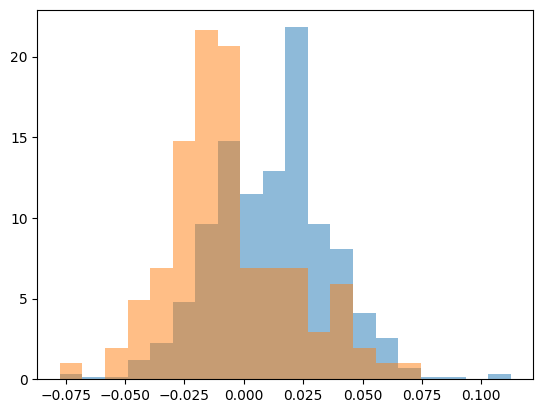

In [14]:
py = X_sum['G1'].values
clip = (-np.inf, np.inf) #(-np.inf, np.inf)

bins = np.linspace(py.min(), py.max(), 20+1)

plt.hist(py[cl == 0], bins=bins, density=True, alpha=0.5)
plt.hist(py[cl == 1], bins=bins, density=True, alpha=0.5)

js = JS_div(py[cl == 0], py[cl == 1], clip=clip)
print(f"JS divergence: {js:.4f}")

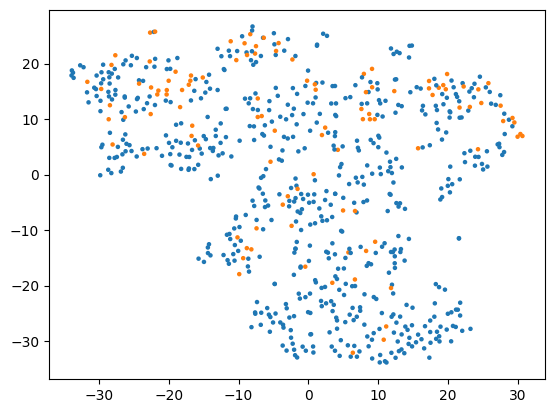

In [15]:
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

cols_p = [f'p{i}' for i in range(256)]
X_p = X_fem[cols_p]

projecter = make_pipeline(TSNE(n_components=2))
p_proj = projecter.fit_transform(X_p)
plt.scatter(p_proj[:, 0], p_proj[:, 1], s=5, c=cl, **tab10_kwargs)

In [81]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

from tqdm.notebook import tqdm

def collate_fn(batch):
  keys = batch[0][-1].keys()
  xs = torch.stack([x for x, y, p, l in batch])
  ys = torch.stack([y for x, y, p, l in batch])
  ps = torch.stack([p for x, y, p, l in batch])
  labels = {k: torch.tensor([l[k] for x, y, p, l in batch]).to(torch.float32) for k in keys}
  return xs, ys, ps, labels

class FEMDataset(Dataset):
  def __init__(self, df, labels):
    self.df = df
    labels = (labels - labels.mean()) / labels.std()
    self.labels = {col: labels[col].values for col in labels.columns}

  def __len__(self):
    return len(self.df)

  def __getitem__(self, i):
    row = self.df.iloc[i].values
    x, y, p = row.reshape(-1, 3).T
    x = torch.from_numpy(x).to(torch.float32)
    y = torch.from_numpy(y).to(torch.float32)
    p = torch.from_numpy(p).to(torch.float32)

    x = (x - x[0]) / 100
    y = (y - y[0]) / 20

    l = {k: v[i] for k, v in self.labels.items()}
    return x, y, p, l

  def get_labels(self):
    return self.labels

class FEMEncoder(nn.Module):
  def __init__(self, in_dim=256*3, hid_dim=256, rep_dim=16, p=0.1, targets: list = ['G1', 'G2', 'G3']):
    super().__init__()
    self.body = nn.Sequential(
        nn.Linear(in_dim, hid_dim),
        nn.Dropout(p=p),
        nn.ReLU(),
        nn.Linear(hid_dim, rep_dim),
        nn.Dropout(p=p),
        nn.ReLU()
    )

    heads = {}
    for k in targets:
      heads[k] = nn.Linear(rep_dim, 1)
    self.heads = nn.ModuleDict(heads)
    self.targets = list(self.heads.keys())

  def get_repv(self, x, y, p):
    h = torch.cat([x, y, p], dim=-1)
    return self.body(h)

  def forward(self, x, y, p):
    h = self.get_repv(x, y, p)

    ys = {}
    for k in self.targets:
      ys[k] = self.heads[k](h).squeeze(-1)
    return ys

In [82]:
def loss_medusa(preds, trues, weight=None):
  assert preds.keys() == trues.keys()

  loss = torch.zeros(1,)
  for k in trues.keys():
    pred, true = preds[k], trues[k]
    loss += nn.functional.mse_loss(pred, true)
  return loss

In [115]:
N = len(X_fem)
r = 1
max_epoch = 100

target_cols = ['Y1', 'G1', 'X1', 'Y5', 'X5', 'Y2', 'G2', 'G4', 'G3', 'Y3']#'Proc_Param8'] # Y1, G1, X1, Y5, X5
loss_fn = loss_medusa

train_set = FEMDataset(X_fem[:int(N*r)], labels=X_sum[target_cols][:int(N*r)])
#val_set = FEMDataset(X_fem[int(N*r):], labels=X_sum[target_cols][int(N*r):])

train_loader = DataLoader(train_set, batch_size=16, collate_fn=collate_fn, shuffle=True)
#val_loader = DataLoader(val_set, batch_size=16, collate_fn=collate_fn, shuffle=False)

In [101]:
for batch in val_loader:
  x, y, p, ls = batch
  ls_pred = model(x, y, p)
  print({k: v.shape for k, v in ls_pred.items()}); break

{'Y1': torch.Size([16]), 'G1': torch.Size([16]), 'X1': torch.Size([16]), 'X5': torch.Size([16])}


In [116]:
model = FEMEncoder(p=0.1, hid_dim=256, rep_dim=32, targets=target_cols)
optimizer = Adam(params=model.parameters(), lr=1e-4, weight_decay=2e-4)

def run_epoch(train, epoch, verbose=True):
  loader = train_loader if train else val_loader
  epoch_loss = []
  bar = tqdm(loader) if verbose else loader
  for batch in bar:
    x, y, p, labels = batch
    labels_pred = model(x, y, p)
    loss = loss_fn(labels_pred, labels)
    if train:
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    epoch_loss.append(loss.item())
  epoch_loss = sum(epoch_loss) / len(epoch_loss)
  return epoch_loss

loss_dict = {'train': [], 'val': []}
for i in range(max_epoch):
  verbose = (i % 10 == 1)
  model.train()
  train_loss = run_epoch(train=True, epoch=i, verbose=verbose)
  loss_dict['train'].append(train_loss)
  print(f"Epoch {i} training loss: {train_loss:.6f}") if verbose else None

  #model.eval()
  #with torch.no_grad():
  #  val_loss = run_epoch(train=False, epoch=i, verbose=verbose)
  #loss_dict['val'].append(val_loss)
  #print(f"Epoch {i} validation loss: {val_loss:.6f}") if verbose else None

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 1 training loss: 9.364885


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 11 training loss: 5.602476


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 21 training loss: 4.562740


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 31 training loss: 3.860499


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 41 training loss: 3.303207


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 51 training loss: 3.104308


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 61 training loss: 2.808437


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 71 training loss: 2.762309


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 81 training loss: 2.588166


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 91 training loss: 2.573789


Feature Y1 - R sq.: 0.774751
Feature G1 - R sq.: 0.705136
Feature X1 - R sq.: 0.453854
Feature Y5 - R sq.: 0.881008
Feature X5 - R sq.: 0.961757
Feature Y2 - R sq.: 0.906880
Feature G2 - R sq.: 0.712643
Feature G4 - R sq.: 0.895571
Feature G3 - R sq.: 0.802870
Feature Y3 - R sq.: 0.926196


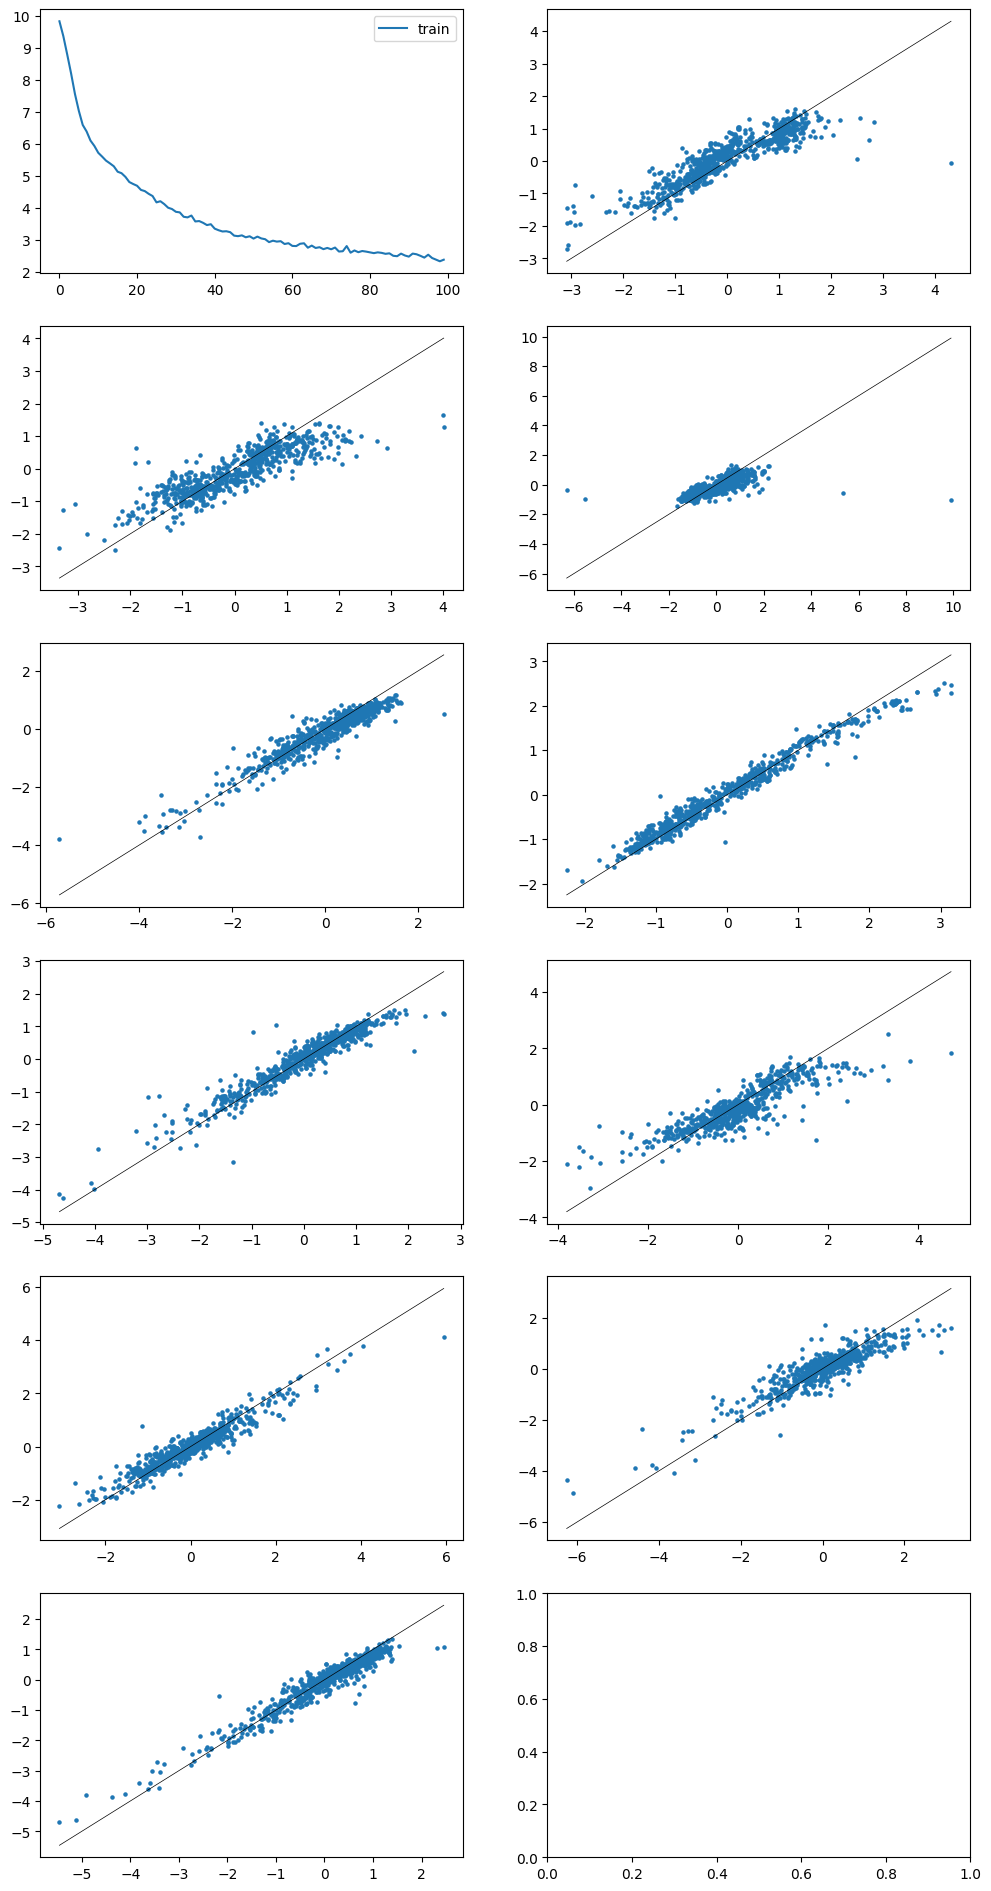

In [117]:
labels = train_set.get_labels()
labels_pred = {k: [] for k in target_cols}
model.eval()
test_loader = DataLoader(train_set, batch_size=16, collate_fn=collate_fn, shuffle=False)
for batch in test_loader:
  x, y, p, ls = batch
  with torch.no_grad():
    out = model(x, y, p)
    for k in target_cols:
      labels_pred[k].append(out[k])

for k in target_cols:
  labels_pred[k] = torch.cat(labels_pred[k]).detach().numpy()

r, c = 6, 2
fig, axes = plt.subplots(r, c, figsize=(6 * c, 4 * r))

axes[0, 0].plot(loss_dict['train'], label='train')
#axes[0, 0].plot(loss_dict['val'], label='val')
axes[0, 0].legend()

for n, k in enumerate(target_cols):
  i, j = (n + 1) // c, (n + 1) % c
  ax = axes[i, j]
  label, label_pred = labels[k], labels_pred[k]

  m, M = np.sort(np.concatenate([label, label_pred]))[[0, -1]]

  ax.scatter(label, label_pred, s=5)
  ax.plot([m, M], [m, M], lw=0.5, c='black')
  ax.set_xlim(m - (M - m) * 0.05, M + (M - m) * 0.05)
  ax.set_ylim(m - (M - m) * 0.05, M + (M - m) * 0.05)

  SST = ((label - label.mean()) ** 2).sum()
  SSE = ((label_pred - label) ** 2).sum()
  print(f"Feature {k} - R sq.: {1-SSE/SST:4f}")

In [118]:
model.eval()
rep_vs = []
for batch in test_loader:
  x, y, p, ls = batch
  with torch.no_grad():
    rep_vs.append(model.get_repv(x, y, p))
rep_vs = torch.cat(rep_vs, dim=0).detach().cpu().numpy()

In [119]:
df_fem_feat = pd.DataFrame(
    data = rep_vs,
    columns = [f'FEM_feat_{i}' for i in range(rep_vs.shape[1])]
)
df_fem_feat.to_csv('drive/MyDrive/25F/Tire/fem_ext.csv')
df_fem_feat

,FEM_feat_0,FEM_feat_1,FEM_feat_2,FEM_feat_3,FEM_feat_4,FEM_feat_5,FEM_feat_6,FEM_feat_7,FEM_feat_8,FEM_feat_9,...,FEM_feat_22,FEM_feat_23,FEM_feat_24,FEM_feat_25,FEM_feat_26,FEM_feat_27,FEM_feat_28,FEM_feat_29,FEM_feat_30,FEM_feat_31
0,0.000000,1.169934,0.000000,0.926075,0.403250,1.363745,0.340032,0.581899,0.0,0.620460,...,0.834892,0.000000,0.000000,0.437479,0.207845,0.000000,0.120531,0.177782,1.141942,0.344536
1,1.119490,0.042507,0.000000,0.000000,0.745294,0.000000,0.041526,0.253923,0.0,0.000000,...,0.000000,1.177655,0.277573,0.000000,0.017776,0.770292,1.169131,0.000000,0.729363,0.000000
2,0.000000,1.002618,0.110985,0.378702,0.044063,0.962854,0.751787,0.899283,0.0,0.000000,...,0.600407,0.385342,0.000000,0.167447,0.000000,0.000000,0.235882,0.041633,1.366231,0.000000
3,1.211907,0.205010,0.000000,1.887298,1.711280,1.293550,0.000000,0.000000,0.0,0.000000,...,0.396572,0.000000,0.000000,0.000000,0.708099,2.084436,1.354333,0.000000,0.527412,1.339051
4,0.000000,1.338665,0.583847,0.000000,0.380407,0.815634,0.338449,1.315293,0.0,0.205591,...,0.849747,0.209619,0.000000,0.805765,0.000000,0.000000,0.364277,0.050753,1.480420,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,0.000000,1.312883,0.000000,1.228563,0.400624,1.873203,0.639410,0.535996,0.0,0.789655,...,0.939924,0.000000,0.000000,0.308277,0.325949,0.000000,0.000000,0.259323,1.338158,0.799919
716,0.000000,0.110902,1.570662,0.000000,0.573883,0.000000,0.000000,1.489732,0.0,0.310687,...,1.513893,0.861284,2.605668,1.394015,0.000000,0.000000,0.645798,0.354696,0.708076,0.000000
717,0.000000,0.218348,1.718949,0.000000,0.405006,0.000000,0.000000,1.100094,0.0,1.153294,...,1.312432,0.000000,1.788300,1.841906,0.672919,0.000000,0.000000,0.804669,0.000000,0.000000
718,0.000000,0.232562,0.665692,0.000000,0.498554,0.000000,0.000000,0.663284,0.0,0.379716,...,0.852744,0.252664,0.852188,0.887282,0.000000,0.000000,0.518292,0.248168,0.494799,0.000000


In [121]:
df_fem_feat

,FEM_feat_0,FEM_feat_1,FEM_feat_2,FEM_feat_3,FEM_feat_4,FEM_feat_5,FEM_feat_6,FEM_feat_7,FEM_feat_8,FEM_feat_9,...,FEM_feat_22,FEM_feat_23,FEM_feat_24,FEM_feat_25,FEM_feat_26,FEM_feat_27,FEM_feat_28,FEM_feat_29,FEM_feat_30,FEM_feat_31
0,0.000000,1.169934,0.000000,0.926075,0.403250,1.363745,0.340032,0.581899,0.0,0.620460,...,0.834892,0.000000,0.000000,0.437479,0.207845,0.000000,0.120531,0.177782,1.141942,0.344536
1,1.119490,0.042507,0.000000,0.000000,0.745294,0.000000,0.041526,0.253923,0.0,0.000000,...,0.000000,1.177655,0.277573,0.000000,0.017776,0.770292,1.169131,0.000000,0.729363,0.000000
2,0.000000,1.002618,0.110985,0.378702,0.044063,0.962854,0.751787,0.899283,0.0,0.000000,...,0.600407,0.385342,0.000000,0.167447,0.000000,0.000000,0.235882,0.041633,1.366231,0.000000
3,1.211907,0.205010,0.000000,1.887298,1.711280,1.293550,0.000000,0.000000,0.0,0.000000,...,0.396572,0.000000,0.000000,0.000000,0.708099,2.084436,1.354333,0.000000,0.527412,1.339051
4,0.000000,1.338665,0.583847,0.000000,0.380407,0.815634,0.338449,1.315293,0.0,0.205591,...,0.849747,0.209619,0.000000,0.805765,0.000000,0.000000,0.364277,0.050753,1.480420,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,0.000000,1.312883,0.000000,1.228563,0.400624,1.873203,0.639410,0.535996,0.0,0.789655,...,0.939924,0.000000,0.000000,0.308277,0.325949,0.000000,0.000000,0.259323,1.338158,0.799919
716,0.000000,0.110902,1.570662,0.000000,0.573883,0.000000,0.000000,1.489732,0.0,0.310687,...,1.513893,0.861284,2.605668,1.394015,0.000000,0.000000,0.645798,0.354696,0.708076,0.000000
717,0.000000,0.218348,1.718949,0.000000,0.405006,0.000000,0.000000,1.100094,0.0,1.153294,...,1.312432,0.000000,1.788300,1.841906,0.672919,0.000000,0.000000,0.804669,0.000000,0.000000
718,0.000000,0.232562,0.665692,0.000000,0.498554,0.000000,0.000000,0.663284,0.0,0.379716,...,0.852744,0.252664,0.852188,0.887282,0.000000,0.000000,0.518292,0.248168,0.494799,0.000000
